In [17]:
from keras.applications import vgg19
from keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

import glob
from PIL import Image
import os

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# parameters setup

imgs_path = r'styles/'
imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 5 # number of most similiar images to retrieve

In [3]:
# load the model

vgg_model = vgg19.VGG19(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer
                      ('fc2').output)

# print the layers of the CNN
feat_extractor.summary()

2022-10-24 21:43:19.099972: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-24 21:43:19.100032: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Cicak): /proc/driver/nvidia/version does not exist
2022-10-24 21:43:19.101105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# get the image paths

files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]

print('number of images:', len(files))

number of images: 3586


In [5]:
# # Create list for images

# img_010 = list(img_path_full.glob('010/*'))
# img_011 = list(img_path_full.glob('011/*'))
# img_012 = list(img_path_full.glob('012/*'))
# img_013 = list(img_path_full.glob('013/*'))
# img_014 = list(img_path_full.glob('014/*'))
# img_015 = list(img_path_full.glob('015/*'))
# img_016 = list(img_path_full.glob('016/*'))
# img_017 = list(img_path_full.glob('017/*'))
# img_018 = list(img_path_full.glob('018/*'))
# img_019 = list(img_path_full.glob('019/*'))
# img_020 = list(img_path_full.glob('020/*'))

In [6]:
# # Train dataset configuration

# img_dataset = tf.keras.utils.image_dataset_from_directory(
#     imgs_path,
#     image_size=(imgs_model_height,imgs_model_width))

### Feed one image into the CNN

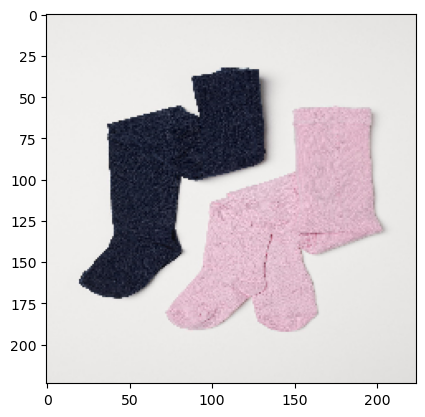

Image loaded successfully!


In [7]:
# load an image in PIL format

original = load_img(files[0], target_size=(imgs_model_width, imgs_model_height))

plt.imshow(original)
plt.show()
print('Image loaded successfully!')

In [8]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [9]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 [==============================] - 1s 731ms/step
features successfully extracted!
number of image features: 4096


array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        1.2851062]], dtype=float32)

## Feed all the images into the CNN

In [10]:
# load all the images and prepare them for feeding into the CNN

import_images = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    import_images.append(image_batch)
    
images = np.vstack(import_images)

processed_imgs = preprocess_input(images.copy())

In [11]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

2022-10-24 21:45:35.329975: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2159173632 exceeds 10% of free system memory.


113/113 [==============================] - 1107s 10s/step
features successfully extracted!


(3586, 4096)

## Compute cosine similarities

In [12]:
# Compute cosine similarities between images

cos_sim = cosine_similarity(imgs_features)

# Store the result into a pandas dataframe

cos_sim_df = pd.DataFrame(cos_sim, columns=files, index=files)
cos_sim_df.head()

,styles/0291338018.jpg,styles/0324502001.jpg,styles/0433444013.jpg,styles/0174057040.jpg,styles/0448515027.jpg,styles/0453239021.jpg,styles/0301517018.jpg,styles/0291338026.jpg,styles/0395127030.jpg,styles/0118458039.jpg,...,styles/0337991007.jpg,styles/0384482009.jpg,styles/0451271005.jpg,styles/0451286002.jpg,styles/0439285001.jpg,styles/0351182003.jpg,styles/0453134008.jpg,styles/0396135008.jpg,styles/0301213001.jpg,styles/0145872053.jpg
styles/0291338018.jpg,1.000000,0.486411,0.397273,0.494855,0.370640,0.391506,0.431495,0.804155,0.412123,0.420561,...,0.355776,0.498967,0.402057,0.427376,0.493509,0.385522,0.515553,0.534281,0.260063,0.432082
styles/0324502001.jpg,0.486411,1.000000,0.348449,0.317419,0.462368,0.441570,0.820594,0.534571,0.335071,0.487733,...,0.454848,0.457902,0.449179,0.357677,0.442990,0.515888,0.417761,0.579122,0.309240,0.375949
styles/0433444013.jpg,0.397273,0.348449,1.000000,0.468220,0.358042,0.340438,0.274350,0.380569,0.594119,0.395346,...,0.197928,0.423885,0.352150,0.459254,0.442552,0.302792,0.512272,0.435246,0.224171,0.538859
styles/0174057040.jpg,0.494855,0.317419,0.468220,1.000000,0.395190,0.453768,0.296512,0.494798,0.519482,0.507681,...,0.272881,0.481523,0.498728,0.657805,0.555770,0.352385,0.537719,0.389666,0.230319,0.614350
styles/0448515027.jpg,0.370640,0.462368,0.358042,0.395190,1.000000,0.658670,0.379443,0.386523,0.428160,0.710934,...,0.327857,0.592535,0.637911,0.444957,0.661736,0.494890,0.445066,0.472029,0.372931,0.501865


### Retrieve most similiar products

In [13]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_sim_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_sim_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


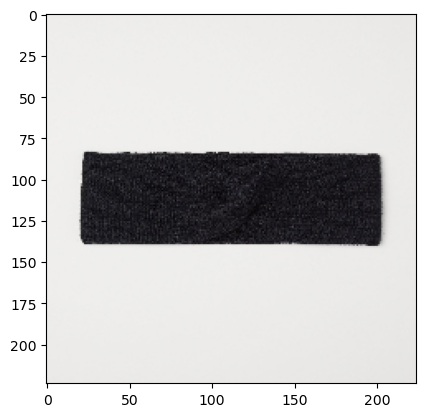

-----------------------------------------------------------------------
most similar products:


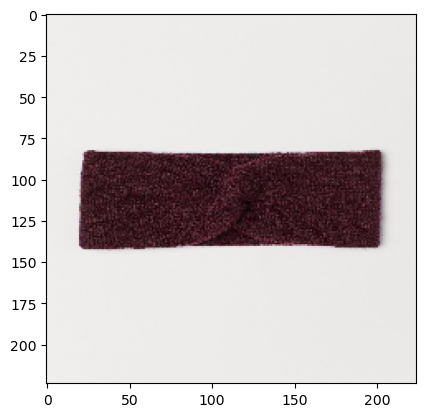

similarity score :  0.92720586


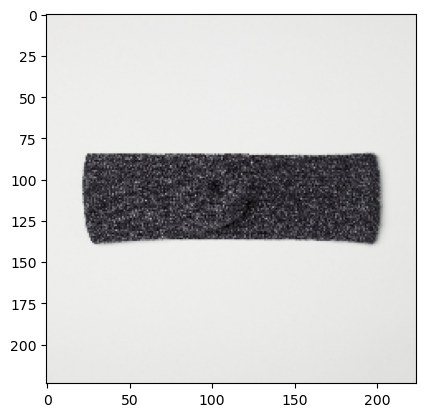

similarity score :  0.92086595


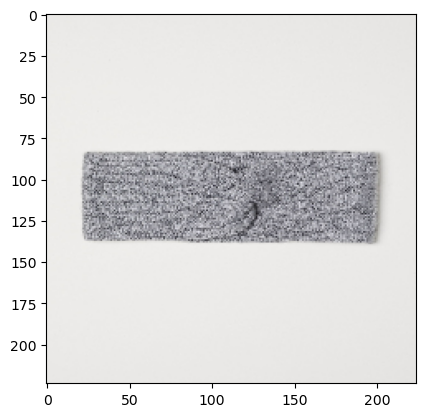

similarity score :  0.84629637


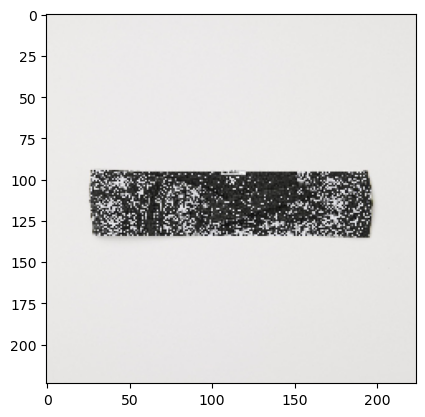

similarity score :  0.8205941


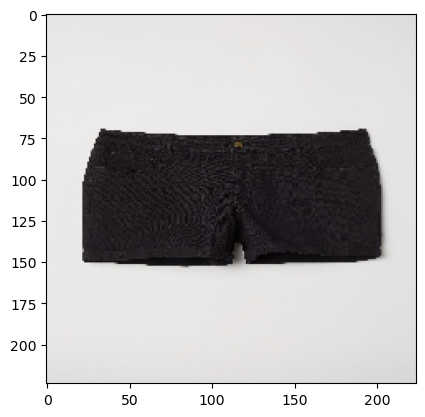

similarity score :  0.79949266


In [14]:
retrieve_most_similar_products(files[1])

-----------------------------------------------------------------------
original product:


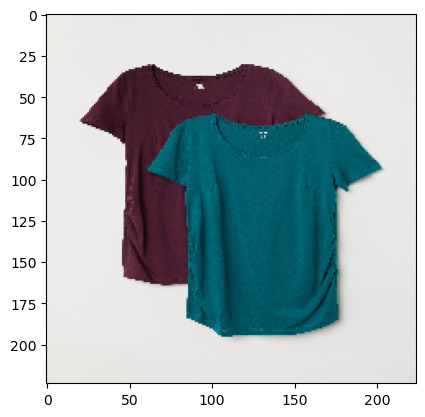

-----------------------------------------------------------------------
most similar products:


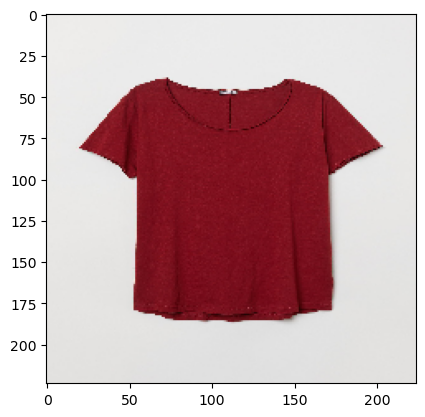

similarity score :  0.84510046


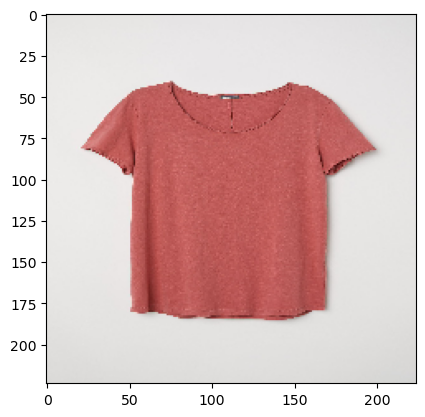

similarity score :  0.8328356


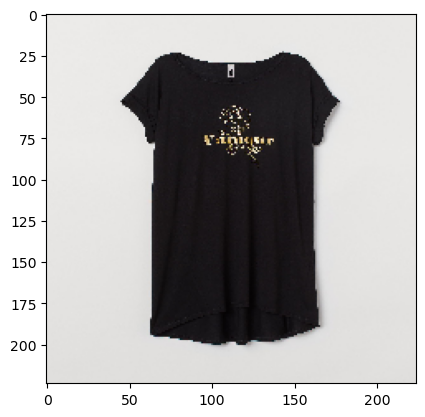

similarity score :  0.83117825


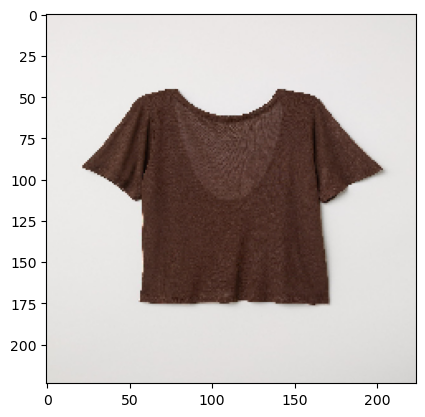

similarity score :  0.83010054


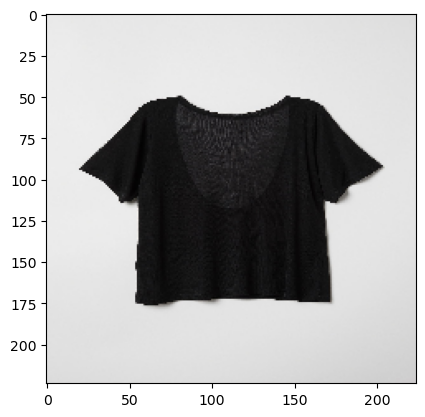

similarity score :  0.82791436


In [15]:
retrieve_most_similar_products(files[2])

-----------------------------------------------------------------------
original product:


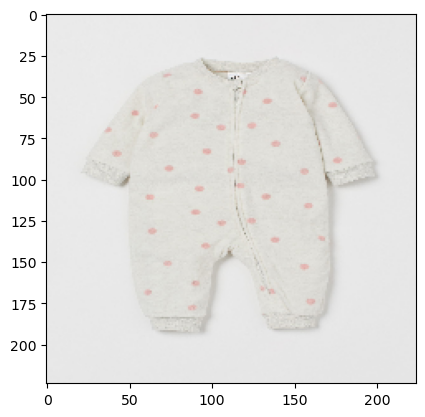

-----------------------------------------------------------------------
most similar products:


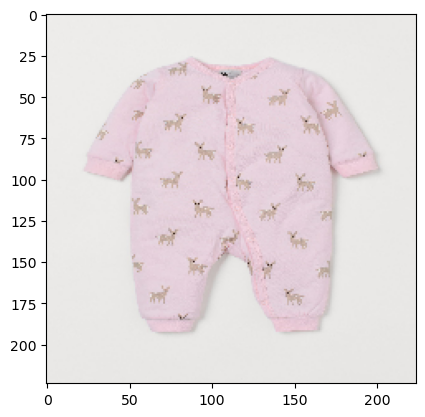

similarity score :  0.9299243


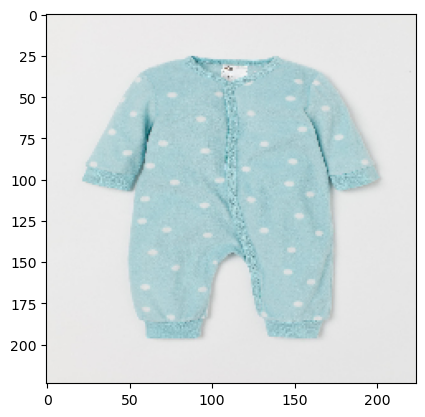

similarity score :  0.92293704


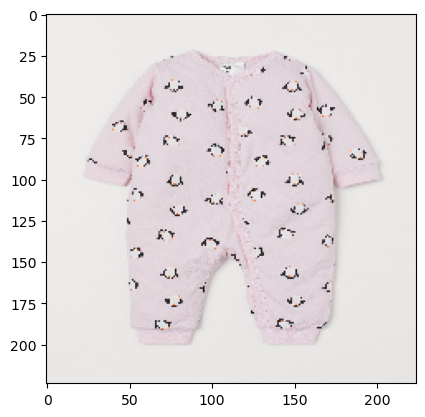

similarity score :  0.8893134


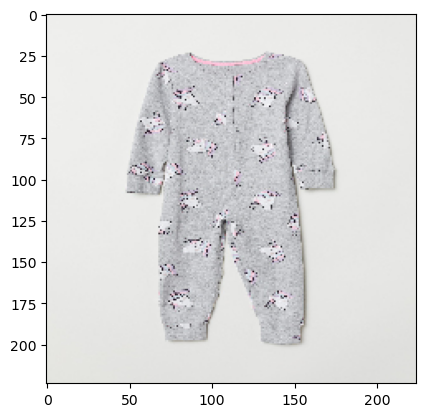

similarity score :  0.8773074


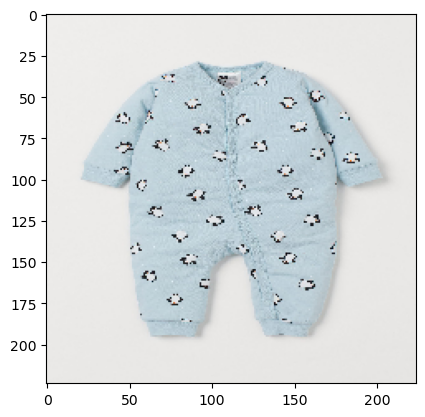

similarity score :  0.8609676


In [18]:
retrieve_most_similar_products(files[3])